In [1]:
import os

ROOT_DATA = os.environ.get('LARD_DATA_ROOT_PATH')
ROOT_PROJECT = os.environ.get('LARD_PROJECT_ROOT_PATH')

print(ROOT_DATA)
print(ROOT_PROJECT)


/fileonssd/runway-dataset/lard-dataset
/home/yeli/workspace/lard/lard-detection


In [3]:
import os
import cv2
import json
import glob
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm

# 判别图像亮度的函数保持不变
def categorize_lightness(path_image):
    image = cv2.imread(path_image, cv2.IMREAD_GRAYSCALE)
    hist = cv2.calcHist([image], [0], None, [256], [0,256])
    
    total_pixels = image.shape[0] * image.shape[1]
    dark_pixels = sum(hist[:50])
    lightness_ratio = dark_pixels / total_pixels
    
    # 使用相对路径
    path_image_relative = path_image.split(f'{ROOT_PROJECT}/')[1] 
    
    # 阈值划分
    if lightness_ratio > 0.7:
        lightness_category = 'dark'
    elif lightness_ratio < 0.2:
        lightness_category = 'bright'
    else:
        lightness_category = 'dim'  # todo 可以考虑移除dim 由于synth数据都是光照良好/海洋干扰, real包括驾驶舱干扰

    return lightness_category, path_image_relative


# 并行处理图像的函数
def classify_images_parallel(image_directory, is_real=False):
    dark_images = []
    dim_images = []
    bright_images = []
    
    extension = 'jpeg' if not is_real else 'png'
    all_path_images = glob.glob(f'{image_directory}/*.{extension}')
    
    with ProcessPoolExecutor(max_workers=24) as executor:
        futures = {executor.submit(categorize_lightness, path_image): path_image for path_image in all_path_images}
        for future in tqdm(as_completed(futures), total=len(futures)):
            lightness_category, path_image_relative = future.result()
            if lightness_category == 'dark':
                dark_images.append(path_image_relative)
            elif lightness_category == 'dim':
                dim_images.append(path_image_relative)
            elif lightness_category == 'bright':
                bright_images.append(path_image_relative)
    
    return dark_images, dim_images, bright_images


datasets = ['train', 'val', 'test_synth', 'test_real_nominal', 'test_real_edge', 'test_real']
path_light_dict = f'{ROOT_PROJECT}/results/tables/eda/light_condition.json'

# 并行计算各图像光照情况
if not os.path.exists(path_light_dict):  # 确保结果文件不存在，避免重复计算
    light_dict = {}
    for dataset in datasets:
        light_dict[dataset] = {}
        path_images = f'{ROOT_PROJECT}/datasets/lard/detection/{dataset}/images/'
        dark_images, dim_images, bright_images = classify_images_parallel(path_images, is_real='real' in dataset)
        light_dict[dataset]['dark'] = dark_images
        light_dict[dataset]['dim'] = dim_images
        light_dict[dataset]['bright'] = bright_images

    with open(path_light_dict, 'w') as file:
        json.dump(light_dict, file, indent=4)


100%|██████████| 1811/1811 [00:10<00:00, 171.56it/s]


In [4]:
import json

def print_keys_tree(data, indent=''):
    if isinstance(data, dict):
        for key in data:
            print(indent + key)
            print_keys_tree(data[key], indent + '    ')
    elif isinstance(data, list):
        for item in data:
            print_keys_tree(item, indent + '    ')

with open(path_light_dict, 'r') as file:
    light_dict = json.load(file)

# 打印树状结构
print_keys_tree(light_dict)

train
    dark
    dim
    bright
val
    dark
    dim
    bright
test_synth
    dark
    dim
    bright
test_real_nominal
    dark
    dim
    bright
test_real_edge
    dark
    dim
    bright
test_real
    dark
    dim
    bright


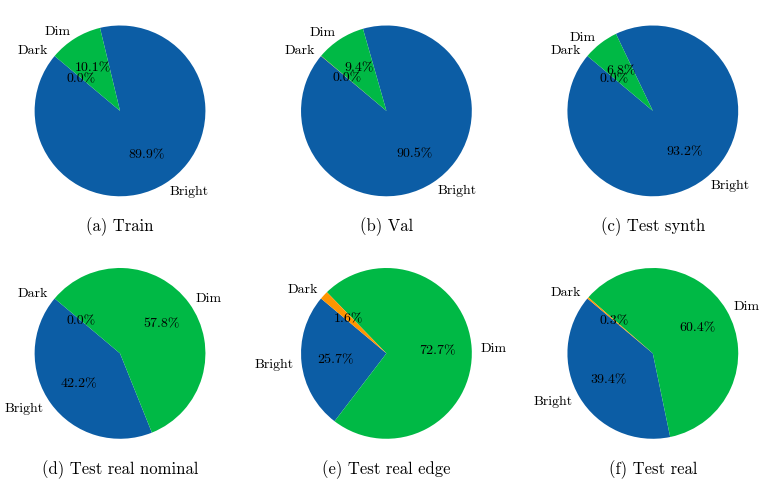

,dataset,bright,dim,dark
0,train,10376,1168,0
1,val,2614,272,1
2,test_synth,2062,150,0
3,test_real_nominal,633,867,0
4,test_real_edge,80,226,5
5,test_real,713,1093,5


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['science', 'no-latex'])

# 统计各数据集光照情况
all_row = []

datasets = ['train', 'val', 'test_synth', 'test_real_nominal', 'test_real_edge', 'test_real']
for dataset in datasets:
    all_row.append([dataset, len(light_dict[dataset]['bright']), len(light_dict[dataset]['dim']), len(light_dict[dataset]['dark'])])

light_confition_stat = pd.DataFrame(all_row, columns=['dataset', 'bright', 'dim', 'dark'])
light_confition_stat.to_csv(f'{ROOT_PROJECT}/results/tables/eda/light_condition.csv', index=False)

# 绘制饼图
fig, axes = plt.subplots(2, 3, figsize=(8, 5))
axes = axes.flatten()
for i, dataset in enumerate(light_confition_stat['dataset']):
    sizes = light_confition_stat.loc[i, ['bright', 'dim', 'dark']]
    axes[i].pie(sizes, labels=['Bright', 'Dim', 'Dark'], autopct='%1.1f%%', startangle=140)
    axes[i].set_title(f"({chr(i+97)}) {dataset.replace('_', ' ').capitalize()}", y=-0.1)

axes[-1].axis('off')
plt.tight_layout()
plt.show()

display(light_confition_stat)

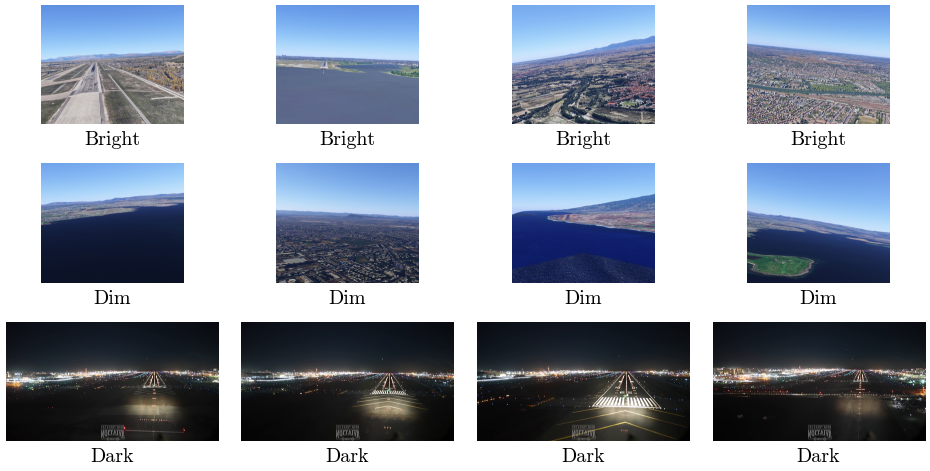

In [5]:
import random
import matplotlib.pyplot as plt
import scienceplots

plt.style.use('science')
plt.rcParams['text.usetex'] = False

# 随机选取dark可视化
datasets = ['train', 'val', 'test_synth', 'test_real_nominal', 'test_real_edge']

# 嵌套的列表解析式，第一个for循环遍历datasets，第二个for循环遍历每个light_dict[dataset]['dark']中的元素，将它们添加到path_dark列表中
path_bright = [item for dataset in datasets for item in light_dict[dataset]['bright']]
path_dim = [item for dataset in datasets for item in light_dict[dataset]['dim']]
path_dark = [item for dataset in datasets for item in light_dict[dataset]['dark']]

def get_random_elements(image_list, num_images):
        return random.sample(image_list, num_images)

# 随机抽取
num_picture = 4
random_bright_images = get_random_elements(path_bright, num_picture)
random_dim_images = get_random_elements(path_dim, num_picture)
random_dark_images = get_random_elements(path_dark, num_picture)

all_images = random_bright_images + random_dim_images + random_dark_images
all_titles = ['Bright' for _ in range(num_picture)] + ['Dim' for _ in range(num_picture)] + ['Dark' for _ in range(num_picture)]

# 绘图
fig, axs = plt.subplots(3, num_picture, figsize=(8, 4), dpi=120)
for i, (path_image, title) in enumerate(zip(all_images, all_titles)):
    row = i // num_picture
    col = i % num_picture
    path_image = f'{ROOT_PROJECT}/{path_image}'
    image = plt.imread(path_image)
    axs[row, col].imshow(image)
    axs[row, col].axis('off')
    axs[row, col].set_title(title, y=-0.25)

plt.tight_layout()
plt.show()
